In [1]:
import random
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Dropout
from keras.models import load_model
from keras.models import Sequential
import numpy as np
import pickle
import json
import nltk
from nltk.stem import WordNetLemmatizer

In [2]:
nltk.download('omw-1.4')
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Bhavisha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bhavisha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Bhavisha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
words = []
classes = []
documents = []
ignore_words = ["?", "!"]
data_file = open("intents.json").read()
intents = json.loads(data_file)

In [4]:
for intent in intents["intents"]:
    for pattern in intent["patterns"]:

        # take each word and tokenize it
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        # adding documents
        documents.append((w, intent["tag"]))

        # adding classes to our class list
        if intent["tag"] not in classes:
            classes.append(intent["tag"])

In [5]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

classes = sorted(list(set(classes)))

print(len(documents), "documents")

print(len(classes), "classes", classes)

print(len(words), "unique lemmatized words", words)


pickle.dump(words, open("words.pkl", "wb"))
pickle.dump(classes, open("classes.pkl", "wb"))

95 documents
27 classes ['about', 'affect', 'anxiety', 'anxiety_cure', 'causes', 'depression', 'depression_cure', 'funny', 'goodbye', 'greeting', 'no_answer', 'prevent', 'professional help', 'recovery', 'sad', 'schizophrenia', 'schizophrenia_cure', 'seek_help', 'symptoms', 'symptoms for adults', 'symptoms for children', 'symptoms for pre-teens', 'thanks', 'treatment', 'unwell', 'what is', 'what to do']
105 unique lemmatized words ["'s", 'a', 'about', 'adult', 'affect', 'affected', 'am', 'anxiety', 'anyone', 'appears', 'are', 'available', 'bored', 'by', 'bye', 'can', 'cause', 'child', 'cure', 'day', 'deal', 'depression', 'disorder', 'do', 'doe', 'doing', 'else', 'feeling', 'find', 'fix', 'for', 'funny', 'get', 'good', 'goodbye', 'ha', 'have', 'health', 'hello', 'help', 'helpful', 'here', 'hey', 'hi', 'how', 'i', 'if', 'illness', 'information', 'is', 'it', 'joke', 'know', 'later', 'lot', 'loved', 'low', 'me', 'mean', 'mental', 'my', 'myself', 'of', 'one', 'option', 'or', 'people', 'perso

In [6]:
training = []
output_empty = [0] * len(classes)
for doc in documents:
    # initializing bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:, 0])
train_y = list(training[:, 1])
print("Training data created")


Training data created


C:\Users\Bhavisha\AppData\Local\Temp/ipykernel_8376/115763920.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)


In [7]:
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               13568     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 27)                1755      
                                                                 
Total params: 23,579
Trainable params: 23,579
Non-trainable params: 0
_________________________________________________________________


In [8]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

C:\Users\Bhavisha\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [9]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="loss", mode ="min", patience = 5, restore_best_weights = True)
callbacks =[earlystopping]

In [12]:
hist = model.fit(np.array(train_x), np.array(train_y), epochs=1000, batch_size=5, verbose=1)
model.save("chatbot_model.h5", hist)
print("model created")

Epoch 1/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0505 - accuracy: 0.9789
Epoch 2/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0480 - accuracy: 0.9895
Epoch 3/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0656 - accuracy: 0.9684
Epoch 4/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0793 - accuracy: 0.9684
Epoch 5/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0530 - accuracy: 0.9684
Epoch 6/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.0635 - accuracy: 0.9684
Epoch 7/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0639 - accuracy: 0.9789
Epoch 8/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0524 - accuracy: 0.9684
Epoch 9/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0662 - accuracy: 0.9684
Epoch 10/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0428 - accuracy: 

19/19 [==============================] - 0s 10ms/step - loss: 0.0730 - accuracy: 0.9684
Epoch 82/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.1096 - accuracy: 0.9579
Epoch 83/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.1316 - accuracy: 0.9474
Epoch 84/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.0580 - accuracy: 0.9684
Epoch 85/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0761 - accuracy: 0.9368
Epoch 86/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0554 - accuracy: 0.9895
Epoch 87/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0936 - accuracy: 0.9579
Epoch 88/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.0692 - accuracy: 0.9684
Epoch 89/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.1131 - accuracy: 0.9368
Epoch 90/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.1223 - accuracy: 0.9579


19/19 [==============================] - 0s 7ms/step - loss: 0.1873 - accuracy: 0.9474
Epoch 162/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0868 - accuracy: 0.9579
Epoch 163/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0534 - accuracy: 0.9895
Epoch 164/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.1116 - accuracy: 0.9368
Epoch 165/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.0607 - accuracy: 0.9789
Epoch 166/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0827 - accuracy: 0.9579
Epoch 167/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0454 - accuracy: 0.9895
Epoch 168/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.0601 - accuracy: 0.9579
Epoch 169/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.1844 - accuracy: 0.9158
Epoch 170/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.0603 - accuracy: 0.

19/19 [==============================] - 0s 9ms/step - loss: 0.0790 - accuracy: 0.9789
Epoch 242/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.1107 - accuracy: 0.9579
Epoch 243/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.1009 - accuracy: 0.9684
Epoch 244/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0793 - accuracy: 0.9579
Epoch 245/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0868 - accuracy: 0.9684
Epoch 246/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.1753 - accuracy: 0.9684
Epoch 247/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0575 - accuracy: 0.9579
Epoch 248/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0683 - accuracy: 0.9684
Epoch 249/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.0811 - accuracy: 0.9579
Epoch 250/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0614 - accurac

19/19 [==============================] - 0s 9ms/step - loss: 0.0461 - accuracy: 0.9789
Epoch 322/1000
19/19 [==============================] - 1s 41ms/step - loss: 0.0626 - accuracy: 0.9789
Epoch 323/1000
19/19 [==============================] - 1s 56ms/step - loss: 0.1125 - accuracy: 0.9579
Epoch 324/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.0642 - accuracy: 0.9579
Epoch 325/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.0490 - accuracy: 0.9684
Epoch 326/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.1652 - accuracy: 0.9474
Epoch 327/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0888 - accuracy: 0.9474
Epoch 328/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0464 - accuracy: 0.9895
Epoch 329/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0595 - accuracy: 0.9684
Epoch 330/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0781 - accu

19/19 [==============================] - 0s 7ms/step - loss: 0.0381 - accuracy: 1.0000
Epoch 402/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.0739 - accuracy: 0.9579
Epoch 403/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.0675 - accuracy: 0.9579
Epoch 404/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.1216 - accuracy: 0.9474
Epoch 405/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0732 - accuracy: 0.9579
Epoch 406/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.0685 - accuracy: 0.9474
Epoch 407/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0454 - accuracy: 0.9579
Epoch 408/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.0380 - accuracy: 0.9895
Epoch 409/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.0549 - accuracy: 0.9684
Epoch 410/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0684 - accuracy: 0.

19/19 [==============================] - 0s 7ms/step - loss: 0.1353 - accuracy: 0.9579
Epoch 482/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0350 - accuracy: 0.9789
Epoch 483/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.0813 - accuracy: 0.9579
Epoch 484/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.0623 - accuracy: 0.9684
Epoch 485/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0367 - accuracy: 0.9895
Epoch 486/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.0545 - accuracy: 0.9684
Epoch 487/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.1021 - accuracy: 0.9895
Epoch 488/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.0978 - accuracy: 0.9579
Epoch 489/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.1516 - accuracy: 0.9474
Epoch 490/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.0508 - accuracy: 0.

19/19 [==============================] - 0s 10ms/step - loss: 0.0297 - accuracy: 1.0000
Epoch 562/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0521 - accuracy: 0.9789
Epoch 563/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0860 - accuracy: 0.9579
Epoch 564/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.1088 - accuracy: 0.9579
Epoch 565/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.0863 - accuracy: 0.9684
Epoch 566/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.1115 - accuracy: 0.9474
Epoch 567/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0749 - accuracy: 0.9579
Epoch 568/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0730 - accuracy: 0.9579
Epoch 569/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.1182 - accuracy: 0.9579
Epoch 570/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.0479 - accuracy: 

19/19 [==============================] - 0s 8ms/step - loss: 0.1160 - accuracy: 0.9474
Epoch 642/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0873 - accuracy: 0.9368
Epoch 643/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0390 - accuracy: 0.9789
Epoch 644/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.0680 - accuracy: 0.9579
Epoch 645/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.0433 - accuracy: 0.9789
Epoch 646/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.0514 - accuracy: 0.9684
Epoch 647/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0716 - accuracy: 0.9474
Epoch 648/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.0322 - accuracy: 0.9789
Epoch 649/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.0676 - accuracy: 0.9579
Epoch 650/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0534 - accuracy:

19/19 [==============================] - 0s 9ms/step - loss: 0.0408 - accuracy: 0.9789
Epoch 722/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.1011 - accuracy: 0.9368
Epoch 723/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.0960 - accuracy: 0.9474
Epoch 724/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.0877 - accuracy: 0.9579
Epoch 725/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.0553 - accuracy: 0.9684
Epoch 726/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.0981 - accuracy: 0.9579
Epoch 727/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0661 - accuracy: 0.9579
Epoch 728/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0512 - accuracy: 0.9579
Epoch 729/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0559 - accuracy: 0.9684
Epoch 730/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.0342 - accuracy: 0.

19/19 [==============================] - 0s 8ms/step - loss: 0.0519 - accuracy: 0.9789
Epoch 802/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.0393 - accuracy: 0.9789
Epoch 803/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0815 - accuracy: 0.9579
Epoch 804/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0512 - accuracy: 0.9579
Epoch 805/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.1226 - accuracy: 0.9474
Epoch 806/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0317 - accuracy: 1.0000
Epoch 807/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0983 - accuracy: 0.9579
Epoch 808/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.1594 - accuracy: 0.9158
Epoch 809/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0931 - accuracy: 0.9263
Epoch 810/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0701 - accura

19/19 [==============================] - 0s 7ms/step - loss: 0.0579 - accuracy: 0.9789
Epoch 882/1000
19/19 [==============================] - 0s 9ms/step - loss: 0.2493 - accuracy: 0.9368
Epoch 883/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.1213 - accuracy: 0.9684
Epoch 884/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.0857 - accuracy: 0.9579
Epoch 885/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.4582 - accuracy: 0.9579
Epoch 886/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0839 - accuracy: 0.9579
Epoch 887/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.1018 - accuracy: 0.9579
Epoch 888/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.0414 - accuracy: 0.9789
Epoch 889/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0370 - accuracy: 0.9789
Epoch 890/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0587 - accuracy: 0.

19/19 [==============================] - 0s 9ms/step - loss: 0.0850 - accuracy: 0.9684
Epoch 962/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0939 - accuracy: 0.9474
Epoch 963/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.1018 - accuracy: 0.9579
Epoch 964/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0380 - accuracy: 0.9789
Epoch 965/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0502 - accuracy: 0.9789
Epoch 966/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.0934 - accuracy: 0.9789
Epoch 967/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.2661 - accuracy: 0.9368
Epoch 968/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.2123 - accuracy: 0.9158
Epoch 969/1000
19/19 [==============================] - 0s 8ms/step - loss: 0.1524 - accuracy: 0.9474
Epoch 970/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0583 - accuracy: 

dict_keys(['loss', 'accuracy'])


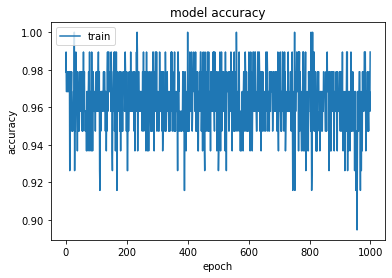

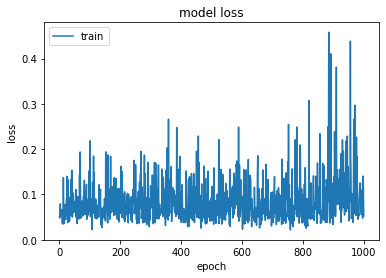

In [13]:
import matplotlib.pyplot as plt
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()